In [5]:
# !pip install yahoo_fin

### Historical OHLCV data for individual stocks

In [8]:
from yahoo_fin import stock_info as finance


def get_stock_data(ticker, start_date, end_date):
    return finance.get_data(ticker, start_date, end_date)

ticker = 'AAPL'
sdate = '20160101'
edate = '20231115'

# Sample usage
df = get_stock_data(ticker, sdate, edate)
df.head()

,open,high,low,close,adjclose,volume,ticker
2016-01-04,25.652500,26.342501,25.500000,26.337500,23.977474,270597600,AAPL
2016-01-05,26.437500,26.462500,25.602501,25.677500,23.376612,223164000,AAPL
2016-01-06,25.139999,25.592501,24.967501,25.174999,22.919142,273829600,AAPL
2016-01-07,24.670000,25.032499,24.107500,24.112499,21.951849,324377600,AAPL
2016-01-08,24.637501,24.777500,24.190001,24.240000,22.067923,283192000,AAPL


In [13]:
### Volume Weighted Average Price (vwap) as a percent of close

In [14]:
import pandas as pd

def calculate_vwap_close_pct(ticker, start_date='20160101', end_date='20231110', rolling_window=63):
    """
    Calculate the percentage difference between the close price and VWAP for a given ticker.
    
    :param ticker: str, the ticker symbol for which to calculate VWAP.
    :param start_date: str, the start date for the data in YYYYMMDD format.
    :param end_date: str, the end date for the data in YYYYMMDD format.
    :param rolling_window: int, the rolling window size for calculating VWAP.
    :return: Pandas Series, the percentage difference between close price and VWAP.
    """
    # Get OHLCV data
    ohlcv_df = finance.get_data(ticker, start_date, end_date)

    # Calculate VWAP
    ohlcv_df['Typical_Price'] = (ohlcv_df['high'] + ohlcv_df['low'] + ohlcv_df['close']) / 3
    ohlcv_df['TP_Volume'] = ohlcv_df['Typical_Price'] * ohlcv_df['volume']
    ohlcv_df['Rolling_TP_Volume'] = ohlcv_df['TP_Volume'].rolling(window=rolling_window).sum()
    ohlcv_df['Rolling_Volume'] = ohlcv_df['volume'].rolling(window=rolling_window).sum()
    ohlcv_df['VWAP'] = ohlcv_df['Rolling_TP_Volume'] / ohlcv_df['Rolling_Volume']

    # Calculate the percentage difference between close and VWAP
    ohlcv_df['vwap_close_pct'] = ohlcv_df['close'] / ohlcv_df['VWAP']

    return ohlcv_df['vwap_close_pct']

# Example usage
vwap_close_pct = calculate_vwap_close_pct('GME')
print(vwap_close_pct.tail())


2023-11-03    0.839592
2023-11-06    0.821930
2023-11-07    0.833020
2023-11-08    0.813551
2023-11-09    0.781550
Name: vwap_close_pct, dtype: float64


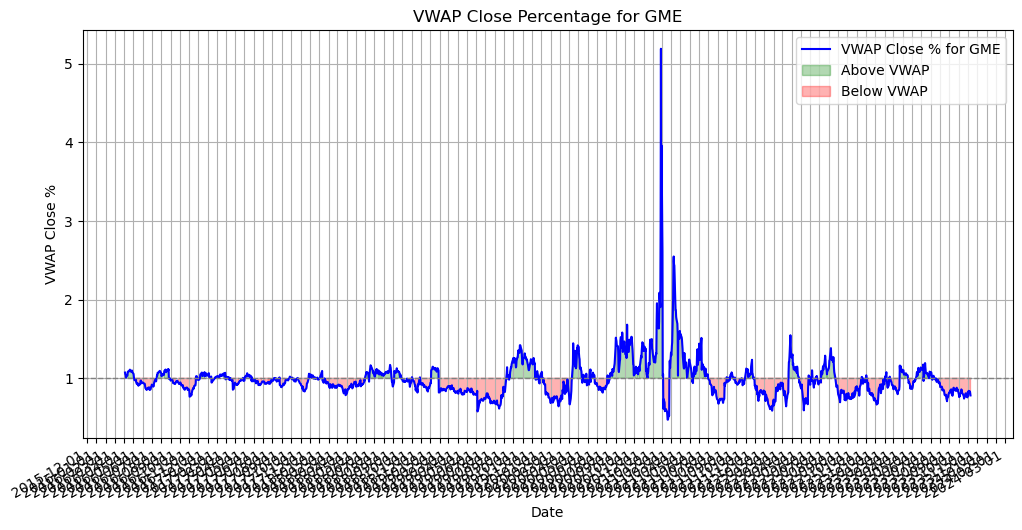

In [15]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_vwap_close_pct(vwap_close_pct, ticker):
    plt.figure(figsize=(12, 6))
    plt.plot(vwap_close_pct, label=f'VWAP Close % for {ticker}', color='blue')

    # Highlight significant deviations
    plt.axhline(1, color='grey', linestyle='--', lw=1)
    plt.fill_between(vwap_close_pct.index, 1, vwap_close_pct, where=(vwap_close_pct > 1.05), color='green', alpha=0.3, label='Above VWAP')
    plt.fill_between(vwap_close_pct.index, 1, vwap_close_pct, where=(vwap_close_pct < 0.95), color='red', alpha=0.3, label='Below VWAP')

    # Annotations and labels
    plt.title(f'VWAP Close Percentage for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('VWAP Close %')
    plt.legend()
    plt.grid(True)

    # Format x-axis to show dates clearly
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gcf().autofmt_xdate()  # Rotation

    plt.show()

# Example usage
vwap_close_pct = calculate_vwap_close_pct('GME')
plot_vwap_close_pct(vwap_close_pct, 'GME')


### IV 30 (z score)

In [32]:
import psycopg2
import pandas as pd
import numpy as np

def calculate_iv_30_z_score(ticker, rolling_window=63):
    # Database connection parameters
    db_params = {
        'user': 'userstring',   #removed for Git
        'password': 'pwstring', #removed for Git
        'host': 'mads-capstone.cmohac77hep9.eu-north-1.rds.amazonaws.com',
        'port': 5432,
        'database': 'mads'
    }

    # Connect to the database and retrieve IV data
    with psycopg2.connect(**db_params) as db_connection:
        db_connection.autocommit = True
        with db_connection.cursor() as cursor:
            select_query = "SELECT * FROM greeks3 WHERE TICKER=%s AND GREEK='iv' AND OPTION_TYPE='all' AND INCREMENT=30"
            cursor.execute(select_query, (ticker,))
            rows = cursor.fetchall()
            df = pd.DataFrame(rows, columns=["ID", "DATE", "INCREMENT", "VALUE", "TICKER", "GREEK", "OPTION_TYPE"]).rename(columns = {'VALUE':'IV_30'})[['DATE', 'IV_30']]
    
    # Convert DATE to datetime and set it as index
    df['DATE'] = pd.to_datetime(df['DATE'])
    df.set_index('DATE', inplace=True)

    # Calculate rolling mean and standard deviation
    df['Rolling_Mean'] = df['IV_30'].rolling(window=rolling_window).mean()
    df['Rolling_Std'] = df['IV_30'].rolling(window=rolling_window).std()

    # Calculate Z-score
    df['IV_30_Z_Score'] = (df['IV_30'] - df['Rolling_Mean']) / df['Rolling_Std']

    return df['IV_30_Z_Score']

# Example usage
ticker = 'GME'
iv_30_z_score = calculate_iv_30_z_score(ticker).fillna(0)
print(iv_30_z_score.tail())  # Display the latest Z-scores


DATE
2014-03-25    0.891412
2014-03-21    0.311792
2014-03-26    1.375802
2014-03-27    0.389517
2014-03-28   -0.033161
Name: IV_30_Z_Score, dtype: float64


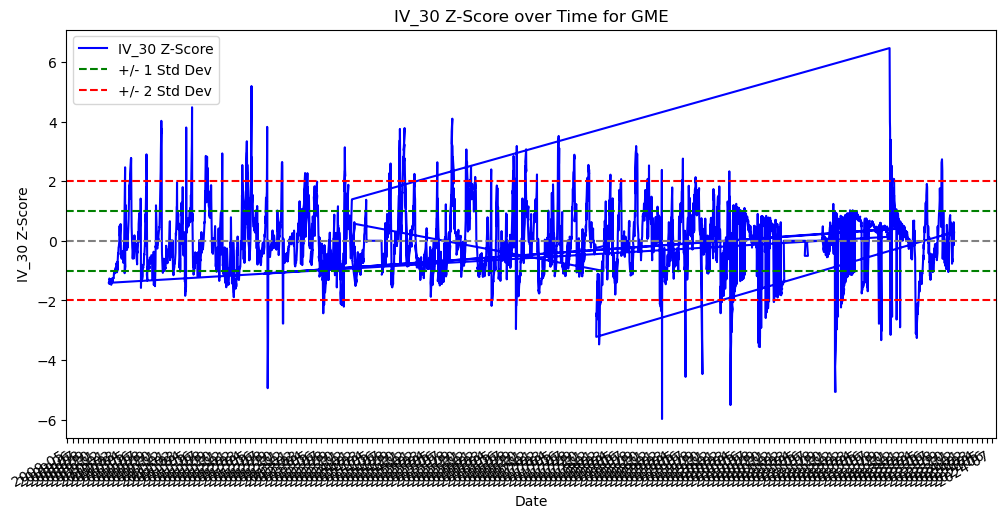

In [33]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_iv_30_z_score(iv_30_z_score, ticker):
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plotting the IV_30 Z-Score
    ax.plot(iv_30_z_score.index, iv_30_z_score, label='IV_30 Z-Score', color='blue')

    # Drawing horizontal lines for significant Z-score thresholds
    ax.axhline(y=0, color='gray', linestyle='--')
    ax.axhline(y=1, color='green', linestyle='--', label='+/- 1 Std Dev')
    ax.axhline(y=-1, color='green', linestyle='--')
    ax.axhline(y=2, color='red', linestyle='--', label='+/- 2 Std Dev')
    ax.axhline(y=-2, color='red', linestyle='--')

    # Setting labels and title
    ax.set_xlabel('Date')
    ax.set_ylabel('IV_30 Z-Score')
    ax.set_title(f'IV_30 Z-Score over Time for {ticker}')

    # Improving date formatting on x-axis
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    fig.autofmt_xdate()

    # Adding a legend
    ax.legend()

    plt.show()

# Example usage
plot_iv_30_z_score(iv_30_z_score, ticker='GME')
